<span style = "color: red"> 
I tried 3 things to improve the performance of the simulation speed. 
</span>

1. Apply Numba jit decorator to simple functions. The jit decorator tells python to compile the function instead of interpreting the code in Python interpreter. 
2. Change electric field interpolation function. Original I used Trilinear interpolation RegularGridInterpolator from package SciPy.Interpolate, which turned to account for 90% time of one iteration loop. Now the new linear interpolation method LinearSpline from a package Interpolation (https://github.com/EconForge/interpolation.py) is used. It's more than 10 times faster than RegularGridInterpolator, and the computed value has very little difference.
3. I also tried to use the Cython package, which can transform the code into C/C++ code and compile it and call the function like package. But I failed because I don't know how to do integrate the interpolation function in Python into C code. 

### Import potentials data in grid points and coordinates from HDF5 file

In [1]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
from numba import jit
import time
# Change interpolation method , https://github.com/EconForge/interpolation.py
from interpolation.splines import LinearSpline, CubicSplines 

In [2]:
#Potential field are stored in a HDF5 file
f=h5py.File('PA_v4.hdf5','r')

In [3]:
#coordinates x,y,z in unit of mm
x=f["Coordinates/X"].value/2.
y=f["Coordinates/Y"].value/2.
z=f["Coordinates/Z"].value/2.

### Set electrodes potentials and calculate spatial potential values
19 electrodes are set to certain potentials to create electric field to ionize Rydberg atoms

Among the 19 values in the list <span style = "color: red"> electrode_set_potentials </span>, the important ones are: 

 *electrode_set_potentials* index  | Electrode name | Value |
  ------------- | ------------- |-------------
  0  | $f_{1}$ under | 195
  1  | $f_{4}$ under | 195
  2  | $f_{1}$ above | -145
  3  | $f_{4}$ above | -232
  4  | MCP cage    | -0.114
  5  | MCP out     | -1900
  6  | Chamber     | 0
  7  | CEM cage    | 4
  8  | deflection ring 1 | 0.3
  9  | deflection ring 2 | -232
  10 | $f_{2}$ under | 195
  11 | $f_{3}$ under | 195
  12 | $f_{2}$ above | -145
  13 | $f_{3}$ above | -232
  
  The rest are related to the detectors readout and are in low values.

In [4]:
#set values of 19 electrodes, for ionization field of state n=30
#electrode_set_potentials=[187.*1.2,187.*1.2,-1.74,-278.*1.2,-0.114*1.2,-1900.,0.,3.97*1.2,-1.74*1.2,-278.*1.2,187.*1.2,187.*1.2,0.3*1.2,-278.*1.2,0.,0.,0.,0.318*1.2,0.307*1.2];
electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];
electrode_set_potentials[9]=-250.
#electrode_set_potentials=[195.,195.,-150.,-545.,-0.114,-1900.,0.,4.,0.3,-545.,430.,430.,-150.,-545.,0.,0.,0.,0.318,0.307];

In [5]:
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
potentials=np.zeros((len(x),len(y),len(z)))
for i in range(19):
    electroden=f["Potential Arrays/electrode"+str(i+1)].value
    potentials+=electrode_set_potentials[i]*electroden/10000.

### Interpolate potential arrays

In [6]:
#generate potential interpolation

from scipy.interpolate import RegularGridInterpolator as rgi
p_interpolation=rgi((x,y,z),potentials)

In [7]:
minlimit = [min(x), min(y), min(z)]
maxlimit = [max(x), max(y), max(z)]
orders = [len(x), len(y), len(z)]
p_interpolation2 = LinearSpline(minlimit, maxlimit, orders, potentials)

Setting
[121 121 173]
(121, 121, 173)


##### Compare two different interpolation method

LinearSpline are 10 times faster and the interpolated value are same with RegularGridInterpolator

In [8]:
%timeit p_interpolation(np.array([102.5,102.5,65.]))[0]

10000 loops, best of 3: 148 µs per loop


In [9]:
%timeit p_interpolation2(np.array([102.5,102.5,65.]))

The slowest run took 2840.22 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 8.83 µs per loop


In [10]:
dz = np.linspace(0,30,31)
zcrd = [[102.5, 102.5, 65.0 + i] for i in dz]
p1 = np.array([p_interpolation(np.array(zcrd[j]))[0] for j in range(len(zcrd))])
p2 = np.array([p_interpolation2(np.array(zcrd[j])) for j in range(len(zcrd))])

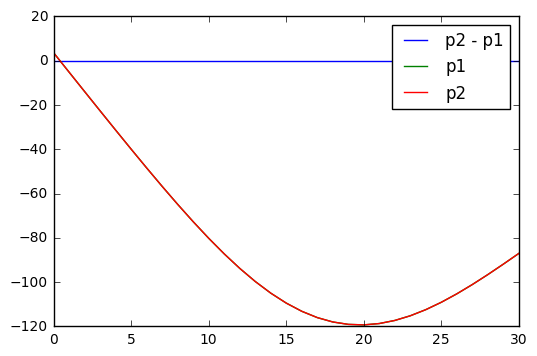

In [11]:
import matplotlib.pyplot as plt
plt.plot(dz, p2-p1,label = "p2 - p1")
plt.plot(dz, p1, label = "p1")
plt.plot(dz, p2, label = "p2")
plt.legend()
plt.show()

Define velocity iteration function and trajectory iteration function for single ion.

MCP detector plane

In [12]:
phi=-82.*np.pi/180.
tmatrix=np.array([[np.cos(phi),0,-np.sin(phi)],
           [0,1,0],
           [np.sin(phi),0,np.cos(phi)]])

In [13]:
#center point of MCP plane
center=(tmatrix.dot(np.array([0.,0.,3.]))*2 + [247,205,214])/2
#c=(241+6*np.cos(phi) + np.tan(- phi)*(247 + 6*np.sin( - phi)))/2.
c=center[2] + np.tan(- phi)* center[0]
#center, c

#### Functions used to simulate ion dynamics

In [14]:
#single ion's position and velocity iteration functions

@jit
def R(ri,vi,dt):                  #delta_t in unit of micro-second, displacement in unit of mm, v in unit of mm/us
    """
    R() calculate ion's position of next time step based on current position and velocity
    """
    x_new=ri[0]+vi[0]*dt
    y_new=ri[1]+vi[1]*dt
    z_new=ri[2]+vi[2]*dt
    return np.array([x_new,y_new,z_new])

@jit
def Gradientforce(ri,vi,delta_t,dr):
    """
    Gradiencforce() calculate force on ion from electrodes potential field.
    It returns the new velocity of ion, by adding acceleration in a small time step to the temporary velocity
    """
    dvx=-100./(1.0364*87.) * (p_interpolation([ri[0]+dr,ri[1],ri[2]])[0]-p_interpolation([ri[0]-dr,ri[1],ri[2]])[0])/(dr*2)
    dvy=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1]+dr,ri[2]])[0]-p_interpolation([ri[0],ri[1]-dr,ri[2]])[0])/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1],ri[2]+dr])[0]-p_interpolation([ri[0],ri[1],ri[2]-dr])[0])/(dr*2)
    vx_new=vi[0]+dvx * dt
    vy_new=vi[1]+dvy * dt
    vz_new=vi[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])

def Gradientforce2(r,v,dt,dr):  
    """
    Gradientforce2() functions the same as Gradientforce(), but with faster interpolation method of electric field
    Gradiencforce2() calculate force on ion from electrodes potential field.
    It returns the new velocity of ion, by adding acceleration in a small time step to the temporary velocity
    """
    rx1 = np.array([r[0]+dr,r[1],r[2]])
    rx2 = np.array([r[0]-dr,r[1],r[2]])
    ry1 = np.array([r[0],r[1]+dr,r[2]])
    ry2 = np.array([r[0],r[1]-dr,r[2]])
    rz1 = np.array([r[0],r[1],r[2]+dr])
    rz2 = np.array([r[0],r[1],r[2]-dr])
    dvx=-100./(1.0364*87.) * (p_interpolation2(rx1)-p_interpolation2(rx2))/(dr*2) #- for positive ions
    dvy=-100./(1.0364*87.) * (p_interpolation2(ry1)-p_interpolation2(ry2))/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolation2(rz1)-p_interpolation2(rz2))/(dr*2)
    vx_new=v[0]+dvx * dt
    vy_new=v[1]+dvy * dt
    vz_new=v[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])


#@jit
def ion_exist(r):
    """
    Given positions of ions, ion_exist tells if the ions reaches the detector plane and electrodes or not.
    It returns the iterabilities of ions, with 0 meaning ions uniterable and 1 meaning ions still iterable.
    """
    ion_number=len(r)
    ion_condition=[0 for i in range(ion_number)]
    for j in range(ion_number):
        r_ionj=r[j]
        ion_condition[j]=(r_ionj>[x[1],y[1],z[1]]).all() and (r_ionj<[x[-3],y[-3],z[-3]]).all() and (r_ionj[2]-np.tan(phi)*r_ionj[0]<=c)
        
    return ion_condition

"""
#Function to calculate two ions coulombic force
def VCoul(ra,rb):
    #coulombic acceleration of Rb ion at ra, due to repulsion of Rb ion at rb
    distance=np.linalg.norm(ra-rb)
    coulf=1.595 * 1.e-6 /distance**2
    return (ra-rb)*coulf/distance
"""
    
@jit
def VCoul(index,r_iter,ion_condition):
    """
    VCoul() calculate Coulumbic force to the indexed ion from the rest existing ions.
    """
    r_origin=r_iter[index]
    ion_number=len(r_iter)
    force=np.zeros((1,3))
    for i in range(ion_number):
        if (i!=index and ion_condition[i]):
            distance=np.linalg.norm(r_origin - r_iter[i])
            coulf=1.595 * 1.e-6 / distance**2
            force += (r_origin - r_iter[i]) * coulf/distance
    return force[0]
    
    
@jit
def cross_ratio(r_n,r_iter,count,dt):
    """
    The last position of ion is usually beyond the limit of the detector plane. 
    To have more precise position and arrival time of the ion, 
    cross_ration calculate the intersetion of the line formed by the last and second last position, and the detector plane,
    and the intersection point is considered as the arrival position. 
    The arrival time of ion is also calibrated.
    """
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    ratio=(r_p[0]-r_n[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= np.array([np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t])
    return r_new


In [15]:
dr=0.5       #dr[mm] is used when calculating gradients
dt=0.01     #dt[us]

In [16]:
%timeit Gradientforce(np.array([102.5,102.5,65.]),np.array([0.,0.,0.]),dt,dr)
%timeit Gradientforce2(np.array([102.5,102.5,65.]),np.array([0.,0.,0.]),dt,dr)

The slowest run took 414.87 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 930 µs per loop
10000 loops, best of 3: 60.5 µs per loop


In [17]:
def trajectories_ions(r_init,v_init,dt):
    """
    trajectories_ions() iterate all ions in tune, given initial ions' positions and initial velocities all being 0.
    In each time step, the velocities are calculated considering both gradient force of electric field and Coulumbic force from other ions.
    Then the new position is calculated.
    After all ions have reached detector, 
    """
    ion_number=len(r_init)
    count=np.zeros(ion_number)
    r_iter=np.zeros((ion_number,3))
    r_n=np.zeros((ion_number,3))
    r_iter=r_init
    v_iter=v_init
    r_n=np.zeros((ion_number,3))
    
    #no appending?
    global condition
    condition = ion_exist(r_iter)
    sequence=[k for k in range(ion_number)]
    while any(condition):
        # while loop condition: ion still in effective volume, and not hit the plane
        """if iondistance<0.01:
            dt=0.0001
        else:
            dt=0.01"""
        for i in sequence:
            if condition[i]:
                r_n[i]=np.array(r_iter[i])
                v_iter[i] = Gradientforce2(r_iter[i],v_iter[i],dt,dr) + VCoul(i,r_iter,condition) * dt
                r_iter[i]=R(r_iter[i],v_iter[i],dt)
                count[i] += 1
        if max(count * dt)>15:
            break
        condition=ion_exist(r_iter)
        #print(r_iter[0])
        
    #map coordinates into detector plane coordinate
    r_final=np.zeros((ion_number,3))
    for k in range(ion_number):
        r_final[k]=cross_ratio(r_n[k],r_iter[k],count[k],dt)
    v_final=v_iter
    #print r_final
    #displacement=np.array(r_new1) - np.array(r_new2)
    ionsituation=np.concatenate((r_final,v_final),axis=1)
    #print(r_final)
    return r_final

##### Initial ions positions in a grid

In [18]:
# 96.8  102.5   66.
#96.9,102.5,66.05
xc=np.linspace(96.9 - 0.05,96.9 + 0.05,11)
yc=np.linspace(102.5 - 0.01,102.5 + 0.01,5)
zc=np.linspace(66.05 - 0.01,66.05 + 0.01,5)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((len(xc)*len(yc)*len(zc),3))
ind=0
tstart=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            ind += 1

tend=time.time()
print(tend-tstart)
print(len(startpoints))

0.0009999275207519531
275


In [19]:
ionfinalpoints=np.zeros((len(startpoints),3))
v=np.zeros((len(startpoints),3))

In [20]:
tstart2=time.time()
ionfinalpoints=trajectories_ions(startpoints,v,dt)
tend2=time.time()
print("Total running time is", tend2-tstart2,'s')

Total running time is 34.26900005340576 s


In [21]:
finalpoints_good=ionfinalpoints[np.linalg.norm(ionfinalpoints[:,:2],axis=1) < 7.25]

In [22]:
print('Max possible efficiency is',finalpoints_good.shape[0]/ionfinalpoints.shape[0])

Max possible efficiency is 0.9636363636363636


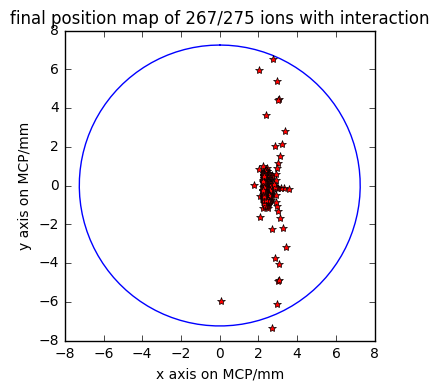

In [23]:
%matplotlib inline
plt.figure()
theta=np.linspace(0,2*np.pi,100)
plt.plot(7.25*np.sin(theta),7.25*np.cos(theta))
plt.axes().set_aspect('equal')
plt.plot(ionfinalpoints[:,0],ionfinalpoints[:,1],'r*')
plt.xlabel("x axis on MCP/mm")
plt.ylabel("y axis on MCP/mm")
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title("final position map of 267/275 ions with interaction")
plt.show()

In [24]:
"""
%matplotlib notebook
newplot=plt.figure()
ionplot=newplot.add_subplot(111,projection='3d')
#mp.plot(MCP[:,0],MCP[:,1],MCP[:,2],label='MCP')
ionplot.plot(startpoints[:,0],startpoints[:,1],startpoints[:,2],'.')
#mp.plot(points[:,0],points[:,1],points[:,2])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Start point, x:94.45 - 94.55, y:102.49 - 102.51, z:55.49 - 55.51 \n ion distance 5um")
plt.show()
"""

'\n%matplotlib notebook\nnewplot=plt.figure()\nionplot=newplot.add_subplot(111,projection=\'3d\')\n#mp.plot(MCP[:,0],MCP[:,1],MCP[:,2],label=\'MCP\')\nionplot.plot(startpoints[:,0],startpoints[:,1],startpoints[:,2],\'.\')\n#mp.plot(points[:,0],points[:,1],points[:,2])\nplt.xlabel("X")\nplt.ylabel("Y")\nplt.title("Start point, x:94.45 - 94.55, y:102.49 - 102.51, z:55.49 - 55.51 \n ion distance 5um")\nplt.show()\n'

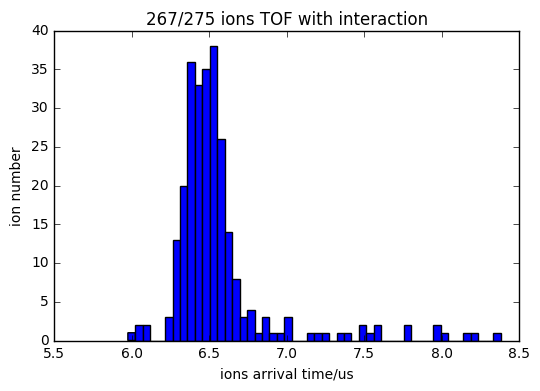

In [25]:
count, bins, ignored = plt.hist(finalpoints_good[:,2], 50)
plt.xlabel("ions arrival time/us")
plt.ylabel("ion number")
plt.title("267/275 ions TOF with interaction")
plt.show()